# Fig 5, Fig S3 plotting

Plots the data associated with Figure 5 and Figure S3.

### Standard Imports

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib as mpl
from cycler import cycler
import pylab
from matplotlib.colors import LogNorm, Normalize

# Plotting parameters
sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.0, 'lines.markersize': 5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))
mpl.rc('text', usetex=False)
tw = 1.5
sns.set_style({"xtick.major.size": 12, "ytick.major.size": 12,
               "xtick.minor.size": 8, "ytick.minor.size": 8,
               'axes.labelsize': 48,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})
mpl.rc('xtick', labelsize=24) 
mpl.rc('ytick', labelsize=24)
mpl.rc('axes', linewidth=1.75)
plt.gcf().subplots_adjust(bottom=0.15)
sns.set_style({'axes.labelsize': 48, 'axes.titlesize': 48})
cm = 1/2.54


# Color variables
cb_green = (102/255, 194/255, 165/255, 0.5)
cb_orange = (252/255, 141/255, 98/255, 0.5)
cb_blue = (141/255, 160/255, 203/255, 0.5)
cb_darkblue = (141/255, 160/255, 203/255, 0.25)
alpha_grey = (215/255, 215/255, 215/255, 1.0)
alpha_val = 0.5
alpha_red = (alpha_val + 1/2, alpha_val, alpha_val)
alpha_black = (alpha_val, alpha_val, alpha_val)
alpha_blue = (alpha_val, alpha_val, alpha_val + 1/2)

%matplotlib inline

### Import data

In [2]:
df = pd.read_excel('./data/CFU_counts.xlsx', sheet_name='Fig 5')

### Plot raw CFU data

This is not one of the figures in the manuscript.

<Figure size 720x1296 with 0 Axes>

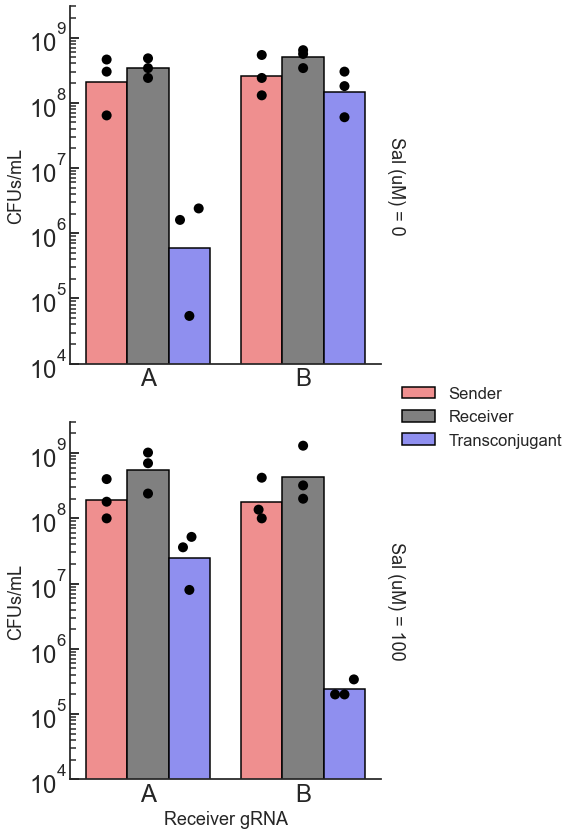

In [7]:
plt.figure(figsize=(10,18))
g = sns.FacetGrid(df, row='Sal (uM)',
                  sharex=False, sharey=True, margin_titles=True,
                  aspect=1, height=6 )

g.map(sns.barplot, 'Receiver gRNA', 'CFUs/mL', 'Strain',
      palette=[alpha_red, alpha_black, alpha_blue], errcolor='k', edgecolor='k',
      ci=None, estimator=stats.mstats.gmean,
      order=['A','B'],
      hue_order=['Sender', 'Receiver', 'Transconjugant'])
g.map(sns.swarmplot, 'Receiver gRNA', 'CFUs/mL', 'Strain',
      palette=['k'], edgecolor='k', s=10, dodge=True,
      order=['A','B'],
      hue_order=['Sender', 'Receiver', 'Transconjugant'],
     )

g.set(yscale='log',
      ylim=(1e4, 3e9)
     )
g.add_legend()

plt.show()

### Calculate transfer rates

In [8]:
# Get transfer rates
rate_df = pd.DataFrame(columns=[
                                'Receiver gRNA',
                                'Sal (uM)',
                                'Transfer Rate',
                                'Geomean Transfer Rate',
                                ])


reps = [1,2,3]
sites = ['A', 'B']
sals = [0, 100]

for s in range(len(sites)):
    for c in range(len(sals)):
        rates = np.empty(len(reps))
        for r in range(len(reps)):
            rep = reps[r]
            site = sites[s]
            sal = sals[c]

            S = df[(df['Replicate'] == rep) &
                   (df['Receiver gRNA'] == site) &
                   (df['Sal (uM)'] == sal) &
                   (df['Strain'] == 'Sender')]['CFUs/mL'].values
            R = df[(df['Replicate'] == rep) &
                   (df['Receiver gRNA'] == site) &
                   (df['Sal (uM)'] == sal) &
                   (df['Strain'] == 'Receiver')]['CFUs/mL'].values
            T = df[(df['Replicate'] == rep) &
                   (df['Receiver gRNA'] == site) &
                   (df['Sal (uM)'] == sal) &
                   (df['Strain'] == 'Transconjugant')]['CFUs/mL'].values

            assert len(S) == 1
            assert len(R) == 1
            assert len(T) == 1

            S = S[0]
            R = R[0]
            T = T[0]

            rate = T/(S*R)
            
            rates[r] = T/(S*R)
            
            if r != len(reps)-1:
                tempdict = pd.DataFrame({'Replicate': rep,
                            'Receiver gRNA': site,
                            'Sal (uM)': sal,
                            'Transfer Rate': rate},
                                        index=[0])
                
                rate_df = pd.concat([rate_df, tempdict], ignore_index=True)

            else:
                tempdict = pd.DataFrame({'Replicate': rep,
                            'Receiver gRNA': site,
                            'Sal (uM)': sal,
                            'Transfer Rate': rate,
                            'Geomean Transfer Rate': stats.mstats.gmean(rates)
                           }, index=[0])
                
                rate_df = pd.concat([rate_df, tempdict], ignore_index=True)
            
                            

### Plot transfer rates

<Figure size 1440x576 with 0 Axes>

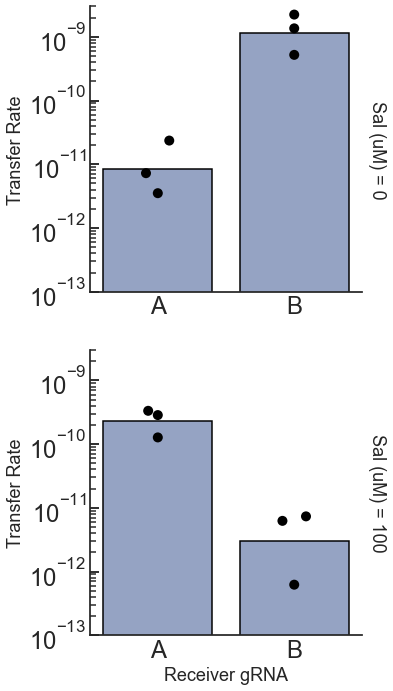

In [12]:
plt.figure(figsize=(20,8))
g = sns.FacetGrid(rate_df, row='Sal (uM)',
                  sharex=False, sharey=True, margin_titles=True,
                  aspect=1.0, height=5 )

g.map(sns.barplot, 'Receiver gRNA', 'Geomean Transfer Rate',
      palette=[cb_blue], ci=None, edgecolor='k',
      order=['A','B']
     )
g.map(sns.swarmplot, 'Receiver gRNA', 'Transfer Rate',
      palette=['k'], edgecolor='k', s=10,
      order=['A','B']
     )

g.set(yscale='log',
      ylim=(1e-13, 3e-9)
     )
g.add_legend()

plt.savefig('./figs/Fig_5C.pdf', bbox_inches='tight')

plt.show()

### Calculate fold changes in transfer rates

In [15]:
AA1 = rate_df[(rate_df['Receiver gRNA'] == 'A') &
                (rate_df['Sal (uM)'] == 100) &
                (rate_df['Replicate'] == 3)
               ]['Geomean Transfer Rate'].values[0]
AB1 = rate_df[(rate_df['Receiver gRNA'] == 'B') &
                (rate_df['Sal (uM)'] == 100) &
                (rate_df['Replicate'] == 3)
               ]['Geomean Transfer Rate'].values[0]

AA0 = rate_df[(rate_df['Receiver gRNA'] == 'A') &
                (rate_df['Sal (uM)'] == 0) &
                (rate_df['Replicate'] == 3)
               ]['Geomean Transfer Rate'].values[0]
AB0 = rate_df[(rate_df['Receiver gRNA'] == 'B') &
                (rate_df['Sal (uM)'] == 0) &
                (rate_df['Replicate'] == 3)
               ]['Geomean Transfer Rate'].values[0]

print(f'The fold change in transfer rate without editing was {AB0/AA0}.')
print(f'The fold change in transfer rate with editing was {AA1/AB1}.')

The fold change in transfer rate without editing was 138.08242437862725.
The fold change in transfer rate with editing was 75.13497842792887.


## Import Fig 3 data for comparison (Fig S3)

In [16]:
df_block = pd.read_excel('./data/CFU_counts.xlsx', sheet_name='Fig 3')

### Calculate transfer rates of Fig 3 data

In [18]:
# Get transfer rates
rate_df_block = pd.DataFrame(columns=[
                                'Message Address',
                                'Receiver gRNA',
                                'Cin (uM)',
                                'Transfer Rate',
                                'Geomean Transfer Rate',
                                ])

reps = [1,2,3]
sites = ['A', 'B']
cins = [0, 1]

for a in range(len(sites)):
    for s in range(len(sites)):
        for c in range(len(cins)):
            rates = np.empty(len(reps))
            for r in range(len(reps)):
                address = sites[a]
                rep = reps[r]
                site = sites[s]
                cin = cins[c]

                S = df_block[(df_block['Replicate'] == rep) &
                       (df_block['Message Address'] == address) &
                       (df_block['Receiver gRNA'] == site) &
                       (df_block['Cin (uM)'] == cin) &
                       (df_block['Strain'] == 'Sender')]['CFUs/mL'].values
                R = df_block[(df_block['Replicate'] == rep) &
                       (df_block['Message Address'] == address) &
                       (df_block['Receiver gRNA'] == site) &
                       (df_block['Cin (uM)'] == cin) &
                       (df_block['Strain'] == 'Receiver')]['CFUs/mL'].values
                T = df_block[(df_block['Replicate'] == rep) &
                       (df_block['Message Address'] == address) &
                       (df_block['Receiver gRNA'] == site) &
                       (df_block['Cin (uM)'] == cin) &
                       (df_block['Strain'] == 'Transconjugant')]['CFUs/mL'].values

                assert len(S) == 1
                assert len(R) == 1
                assert len(T) == 1

                S = S[0]
                R = R[0]
                T = T[0]

                rate = T/(S*R)

                rates[r] = rate

                if r != len(reps)-1:
                    tempdict = pd.DataFrame({'Replicate': rep,
                                'Message Address': address,
                                'Receiver gRNA': site,
                                'Cin (uM)': cin,
                                'Transfer Rate': rate}, index=[0])

                    rate_df_block = pd.concat([rate_df_block, tempdict], ignore_index=True)
                else:
                    tempdict = pd.DataFrame({'Replicate': rep,
                                'Message Address': address,
                                'Receiver gRNA': site,
                                'Cin (uM)': cin,
                                'Transfer Rate': rate,
                                'Geomean Transfer Rate': stats.mstats.gmean(rates)
                               }, index=[0])
                    
                    rate_df_block = pd.concat([rate_df_block, tempdict], ignore_index=True)
                    

In [25]:
# Get geometric mean transfer rate of the four Cin=1 conditions
rate_df_block1 = rate_df_block[rate_df_block['Cin (uM)']==1]
rate_df_block_geomeans = rate_df_block1[rate_df_block1['Replicate'] == 3]

rate_df_block_geomeans

,Message Address,Receiver gRNA,Cin (uM),Transfer Rate,Geomean Transfer Rate,Replicate
5,A,A,1,0.0,0.0,3.0
11,A,B,1,0.0,0.0,3.0
17,B,A,1,0.0,0.0,3.0
23,B,B,1,0.0,0.0,3.0


### Organize transfer rates of Fig 5 data

We will create an analogous dataframe of Fig 5 geometric mean transfer rates

In [30]:
sal_vals = [0, 100] #equivalent to message address being A or B
address_vals = ['A','B']
gRNA_vals = ['A','B']

rate_df_geomeans = pd.DataFrame(columns=['Message Address',
                                         'Receiver gRNA',
                                         'Geomean Transfer Rate'])
for s in range(len(sal_vals)):
    for g in range(len(gRNA_vals)):
        sal = sal_vals[s]
        grna = gRNA_vals[g]
        address = address_vals[s]
        
        gmean_rate = rate_df[(rate_df['Sal (uM)']==sal) &
                             (rate_df['Receiver gRNA']==grna) &
                             (rate_df['Replicate']==3)]['Geomean Transfer Rate'].values
        assert len(gmean_rate)==1
        tempdf = pd.DataFrame({'Message Address': address,
                               'Receiver gRNA': grna,
                               'Geomean Transfer Rate': gmean_rate[0]},
                              index=[0])
        
        rate_df_geomeans = pd.concat([rate_df_geomeans, tempdf], ignore_index=True)
        
rate_df_geomeans

,Message Address,Receiver gRNA,Geomean Transfer Rate
0,A,A,0.0
1,A,B,0.0
2,B,A,0.0
3,B,B,0.0


Since both dataframes are now in the same ordering, we can directly extract the values as they are.

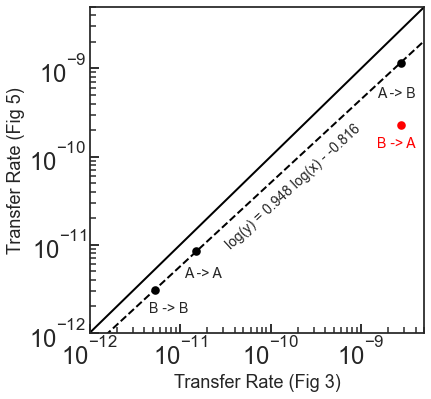

In [43]:
fig3_rates = rate_df_block_geomeans['Geomean Transfer Rate'].values
fig5_rates = rate_df_geomeans['Geomean Transfer Rate'].values

plt.figure(figsize=(6,6))
plt.scatter(fig3_rates[[0,1,3]],
            fig5_rates[[0,1,3]],
            s=50,
            c='k',
           )
plt.scatter(fig3_rates[2],
            fig5_rates[2],
            s=50,
            c='r',
           )
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Transfer Rate (Fig 3)')
plt.ylabel('Transfer Rate (Fig 5)')

# find line of best fit through 3 'colinear' points
a, b = np.polyfit(np.log10(fig3_rates[[0,1,3]].astype(float)),
                  np.log10(fig5_rates[[0,1,3]].astype(float)),
                  1
                 )

xmin, xmax = plt.gca().get_xlim()
ymin, ymax = plt.gca().get_ylim()

# Plot line of best fit
plt.plot([1e-12, 1e-8],
         [10**(a*(-12) + b), 10**(a*(-8) + b)],
         'k--')
# Plot logy=logx
plt.plot([1e-12, 1e-8],
         [1e-12, 1e-8],
         'k-')

# Label Transfers
plt.text(fig3_rates[0]*.75,
         fig5_rates[0]*.5,
         'A -> A',
         fontsize=14,)
plt.text(fig3_rates[1]*.55,
         fig5_rates[1]*.4,
         'A -> B',
         fontsize=14,)
plt.text(fig3_rates[3]*.85,
         fig5_rates[3]*.55,
         'B -> B',
         fontsize=14,)
plt.text(fig3_rates[2]*.55,
         fig5_rates[2]*.55,
         'B -> A',
         fontsize=14,
         c='r')
plt.text(3e-11,
         9e-12,
         f'log(y) = {a:.3f} log(x) - {b:.3f}',
         rotation = 45*a,
         fontsize=14,
        )


plt.gca().set_xlim((1e-12, 5e-9))
plt.gca().set_ylim((1e-12, 5e-9))

plt.savefig('./figs/Fig_S3.pdf')

plt.show()

### Calculate fold difference in observed Fig 5 rate from expected Fig 5 rate

For the B-to-A transfer marked in red above, we can calculate the fold change between the observed Fig 5 transfer rate and the expected Fig 5 transfer rate from the line of best fit.

In [46]:
predicted_SU_fig4 = 10**(a*np.log10(fig3_rates[2]) + b)
fc = predicted_SU_fig4 / fig5_rates[2]

print(f'The fold change between the observed and expected Fig 5 transfer rate for the B->A transfer is {fc}.')

The fold change between the observed and expected Fig 5 transfer rate for the B->A transfer is 5.089325638424153.
